# Comparing Optimal Transport Methods for Nested Distance Computation

The goal of this notebook is to compare the performance of different optimal transport methods in computing the nested distance for an example of a stochastic tree. We evaluate the following methods:

1. **Algorithm 1:** Linear Programming on Tree Structure  
   *From:* **Nested Sinkhorn Divergence To Compute The Nested Distance**  
   *Alois Pichler & Michael Weinhardt*

2. **Algorithm 2:** POT Package to Solve the Inner OT Problem
   *From:* **Nested Sinkhorn Divergence To Compute The Nested Distance**  
   *Alois Pichler & Michael Weinhardt*

3. **Algorithm 3:** Sinkhorn Iteration on Trees  
   *From:* **Nested Sinkhorn Divergence To Compute The Nested Distance**  
   *Alois Pichler & Michael Weinhardt*

4. **Algorithm 4:** Linear Programming on Weighted Sample Paths  
   *From:* **Computational Methods for Adapted Optimal Transport**  
   *Stephan Eckstein and Gudmund Pammer*

In [2]:
import pickle
import time


import os
import sys
trees_path = os.path.abspath('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Trees')

# Add it to sys.path if not already present
if trees_path not in sys.path:
    sys.path.append(trees_path)
from Tree_Node import *
from TreeAnalysis import *
from TreeVisualization import *
from Save_Load_trees import *
from Tree_AWD_utilities import *

# Define the absolute path to the AWD_trees folder
awd_trees_path = os.path.abspath('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/AWD_trees')

# Add it to sys.path if not already present
if awd_trees_path not in sys.path:
    sys.path.append(awd_trees_path)

from Nested_Dist_Algo import compute_nested_distance
import time
from Gurobi_AOT import *


In [3]:
# Load the trees
tree_1_root = load_tree('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Trees/Data_trees_exemple', 'tree_1.pkl')
tree_2_root = load_tree('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Trees/Data_trees_exemple', 'tree_2.pkl')

Tree successfully loaded from /Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Trees/Data_trees_exemple/tree_1.pkl
Tree successfully loaded from /Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Trees/Data_trees_exemple/tree_2.pkl


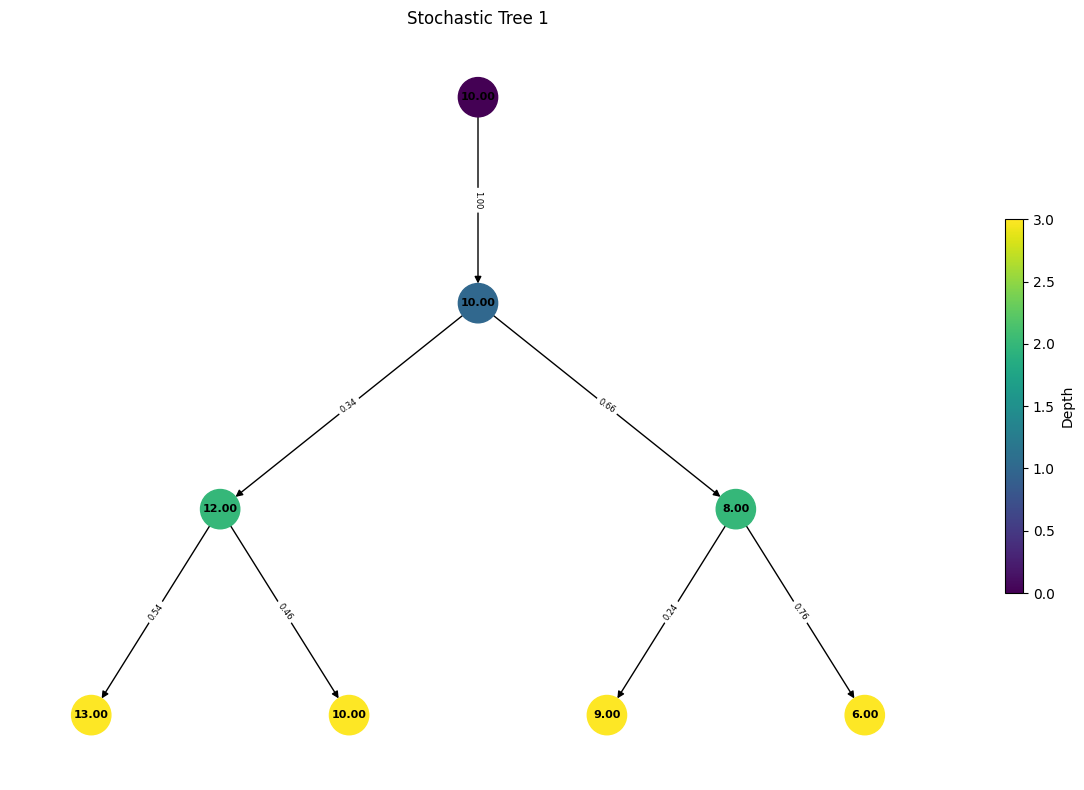

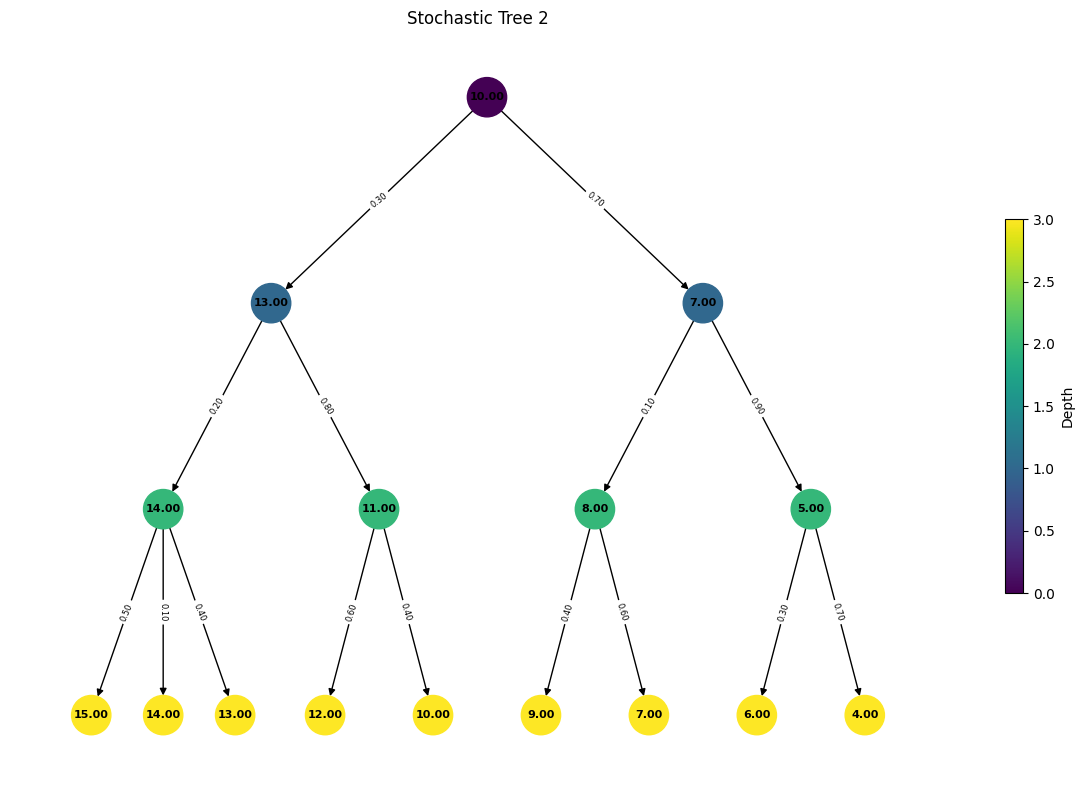


Tree 1 (Path and Weight Format):
Paths:
[[10 10 12 13]
 [10 10 12 10]
 [10 10  8  9]
 [10 10  8  6]]
Weights:
[0.1836 0.1564 0.1584 0.5016]

Tree 2 (Path and Weight Format):
Paths:
[[10 13 14 15]
 [10 13 14 14]
 [10 13 14 13]
 [10 13 11 12]
 [10 13 11 10]
 [10  7  8  9]
 [10  7  8  7]
 [10  7  5  6]
 [10  7  5  4]]
Weights:
[0.03  0.006 0.024 0.144 0.096 0.028 0.042 0.189 0.441]


In [4]:
# Determine the maximum depth of the trees
max_depth = get_depth(tree_1_root)

visualize_tree(tree_1_root, title="Stochastic Tree 1")
visualize_tree(tree_2_root, title="Stochastic Tree 2")

formatted_tree_1 = get_sample_paths(tree_1_root)
formatted_tree_2 = get_sample_paths(tree_2_root)

display_tree_data(formatted_tree_1, "Tree 1")
display_tree_data(formatted_tree_2, "Tree 2")

In [5]:
def print_results(distance, prob_matrix, elapsed_time):
    """Prints the nested distance, probability matrix, and computation time in a formatted way."""
    print(f"Nested Distance: {distance}\n")
    print(f"Final Probability Matrix:")
    for row in prob_matrix:
        print(" | ".join(f"{value:.5f}" for value in row))
    print(f"\nComputation Time: {elapsed_time:.4f} seconds\n")
    print("-" * 50 + "\n")

### Linear Program

In [6]:
start_time = time.time()

distance, final_prob_matrix = compute_nested_distance(
    tree_1_root, tree_2_root, max_depth, method="solver_lp", return_matrix=True, lambda_reg=0
)

end_time = time.time()
elapsed_time = end_time - start_time

print_results(distance, final_prob_matrix, elapsed_time)

Nested Distance: 10.08776

Final Probability Matrix:
0.00240 | 0.00600 | 0.02400 | 0.02268 | 0.00000 | 0.00000 | 0.03780 | 0.00000 | 0.09072
0.02760 | 0.00000 | 0.00000 | 0.00252 | 0.01680 | 0.02800 | 0.00420 | 0.05040 | 0.02688
0.00000 | 0.00000 | 0.00000 | 0.00000 | 0.04752 | 0.00000 | 0.00000 | 0.00000 | 0.11088
0.00000 | 0.00000 | 0.00000 | 0.11880 | 0.03168 | 0.00000 | 0.00000 | 0.13860 | 0.21252

Computation Time: 0.0246 seconds

--------------------------------------------------



### POT Package

In [7]:
start_time = time.time()

distance, final_prob_matrix = compute_nested_distance(
    tree_1_root, tree_2_root, max_depth, method="solver_pot", return_matrix=True, lambda_reg=0
)

end_time = time.time()
elapsed_time = end_time - start_time

print_results(distance, final_prob_matrix, elapsed_time)

Nested Distance: 10.087759999999998

Final Probability Matrix:
0.03000 | 0.00240 | 0.00000 | 0.02268 | 0.00000 | 0.00000 | 0.03780 | 0.00000 | 0.09072
0.00000 | 0.00360 | 0.02400 | 0.00252 | 0.01680 | 0.02800 | 0.00420 | 0.05040 | 0.02688
0.00000 | 0.00000 | 0.00000 | 0.00000 | 0.04752 | 0.00000 | 0.00000 | 0.00000 | 0.11088
0.00000 | 0.00000 | 0.00000 | 0.11880 | 0.03168 | 0.00000 | 0.00000 | 0.13860 | 0.21252

Computation Time: 0.0077 seconds

--------------------------------------------------



### Sinkhorn Algorithm with Regularization

In [8]:
# Start timing the Sinkhorn with regularization computation
start_time = time.time()

# Compute nested distance using Sinkhorn iteration with regularization
distance_sinkhorn_reg, final_prob_matrix_sinkhorn_reg = compute_nested_distance(
    tree_1_root, tree_2_root, max_depth, method="Sinkhorn", return_matrix=True, lambda_reg=3
)

# End timing
end_time = time.time()
elapsed_time_sinkhorn_reg = end_time - start_time

print_results(distance_sinkhorn_reg, final_prob_matrix_sinkhorn_reg, elapsed_time_sinkhorn_reg)

Nested Distance: 10.088481704185343

Final Probability Matrix:
0.01619 | 0.00324 | 0.01295 | 0.02269 | 0.00000 | 0.01506 | 0.02258 | 0.02726 | 0.06361
0.01379 | 0.00276 | 0.01103 | 0.00252 | 0.01681 | 0.01283 | 0.01924 | 0.02322 | 0.05419
0.00000 | 0.00000 | 0.00000 | 0.02851 | 0.01901 | 0.00007 | 0.00000 | 0.03324 | 0.07757
0.00001 | 0.00000 | 0.00001 | 0.09028 | 0.06018 | 0.00005 | 0.00018 | 0.10527 | 0.24563

Computation Time: 0.0196 seconds

--------------------------------------------------



### Computing Nested Distance Using Gurobi (Linear Programming)

In [9]:
def cost_function(x, y):
    """Cost function: L1 distance."""
    return np.sum(np.abs(x - y))

start_time = time.time()

val_gurobi, pi_gurobi = gurobi_bm(
    [formatted_tree_1, formatted_tree_2],
    f=cost_function,
    r_opti=1,
    causal=1,
    anticausal=1,
    outputflag=0
)

end_time = time.time()
elapsed_time_gurobi = end_time - start_time


print_results(val_gurobi, pi_gurobi, elapsed_time_gurobi)

Set parameter Username
Set parameter LicenseID to value 2604970
Academic license - for non-commercial use only - expires 2026-01-03
Nested Distance: 10.08776

Final Probability Matrix:
0.03000 | 0.00000 | 0.00240 | 0.02268 | 0.00000 | 0.02800 | 0.00980 | 0.05040 | 0.04032
0.00000 | 0.00600 | 0.02160 | 0.00252 | 0.01680 | 0.00000 | 0.03220 | 0.00000 | 0.07728
0.00000 | 0.00000 | 0.00000 | 0.04752 | 0.00000 | 0.00000 | 0.00000 | 0.11088 | 0.00000
0.00000 | 0.00000 | 0.00000 | 0.07128 | 0.07920 | 0.00000 | 0.00000 | 0.02772 | 0.32340

Computation Time: 0.0480 seconds

--------------------------------------------------

